In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense   
import os
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

2025-09-02 10:27:43.556739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756808863.901502      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756808863.998454      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class_names=['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label={class_name:i for i, class_name in enumerate(class_names)}
num_classes=len(class_names)
IMAGE_SIZE=(224,224)

In [3]:
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [4]:
def load_data():
    datasets=['/kaggle/input/intel-image-classification/seg_train/seg_train',
              '/kaggle/input/intel-image-classification/seg_test/seg_test']
    output=[]

    for dataset in datasets:
        images=[]
        labels=[]
        print("Laoading".format(dataset))  

        for folder in os.listdir(dataset):
            label=class_names_label[folder]   
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                img_path=os.path.join(os.path.join(dataset,folder),file) 
                image=cv2.imread(img_path)
                image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image=cv2.resize(image,IMAGE_SIZE)

                images.append(image)
                labels.append(label)
        images=np.array(images,dtype='float32')
        labels=np.array(labels,dtype='int32')
        output.append((images,labels))

    return output


In [5]:
(train_images,train_labels),(test_images,test_labels)=load_data()

Laoading


100%|██████████| 2404/2404 [00:30<00:00, 77.59it/s]


Laoading


100%|██████████| 553/553 [00:07<00:00, 70.88it/s]


In [6]:
train_images.shape

(14034, 224, 224, 3)

In [7]:
train_labels.shape

(14034,)

In [8]:
test_images.shape

(3000, 224, 224, 3)

In [9]:
test_labels.shape

(3000,)

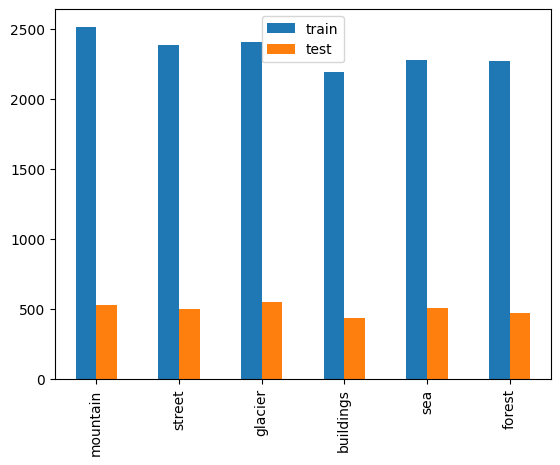

In [10]:
_,train_counts=np.unique(train_labels,return_counts=True)
_,test_counts=np.unique(test_labels,return_counts=True)
pd.DataFrame({'train':train_counts,'test':test_counts},index=class_names).plot.bar()
plt.show()

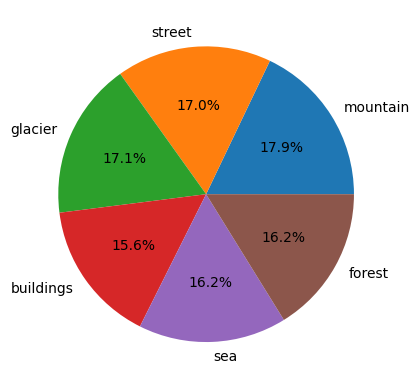

In [11]:
plt.pie(train_counts,explode=(0, 0, 0, 0, 0, 0),labels=class_names,autopct="%1.1f%%")
plt.show()

In [12]:
train_images=train_images/255
test_images=test_images/255

In [13]:
def display_random_image(class_names,images,labels):
    index=np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Image #{} : ".format(index)+class_names[labels[index]])

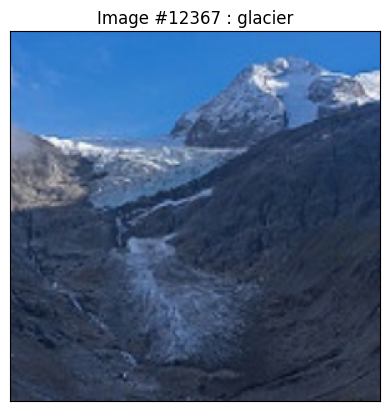

In [14]:
display_random_image(class_names,train_images,train_labels)

In [15]:
def display_examples(class_names,images,labels):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Some Example Of The Image From Dataset',fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i],cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

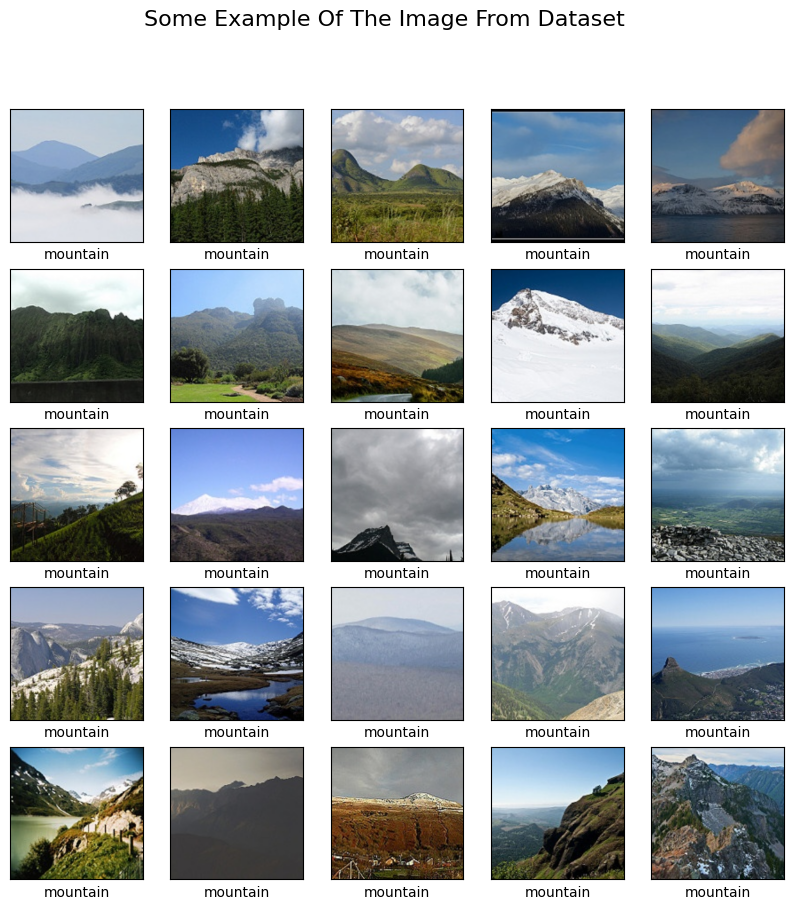

In [16]:
display_examples(class_names,train_images,train_labels)

In [17]:
train_images.shape

(14034, 224, 224, 3)

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [19]:
CNN=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    Conv2D(16,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64,(5,5),activation='relu'),
    #Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(32,activation='relu'),
    Dropout(.5),
    Dense(64,activation='relu'),
    Dropout(.5),
    Dense(6,activation='softmax')
])
CNN.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history=CNN.fit(train_images,train_labels,batch_size=64,epochs=18,validation_data=(test_images,test_labels))

I0000 00:00:1756809116.534692      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756809116.535437      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/18


I0000 00:00:1756809141.842778      67 service.cc:148] XLA service 0x7b0fa800c410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756809141.845580      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756809141.845602      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756809142.335063      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/220 ━━━━━━━━━━━━━━━━━━━━ 59:41 16s/step - accuracy: 0.2188 - loss: 1.7897

I0000 00:00:1756809155.322147      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 198ms/step - accuracy: 0.2575 - loss: 1.7603 - val_accuracy: 0.4467 - val_loss: 1.3653
Epoch 2/18
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - accuracy: 0.4026 - loss: 1.4022 - val_accuracy: 0.4917 - val_loss: 1.1794
Epoch 3/18
220/220 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.4387 - loss: 1.2644 - val_accuracy: 0.5317 - val_loss: 1.0582
Epoch 4/18
220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.4615 - loss: 1.1792 - val_accuracy: 0.5483 - val_loss: 1.0198
Epoch 5/18
220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.4982 - loss: 1.0919 - val_accuracy: 0.5427 - val_loss: 0.9835
Epoch 6/18
220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.5118 - loss: 1.0448 - val_accuracy: 0.5607 - val_loss: 0.9484
Epoch 7/18
220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - accuracy: 0.5298 - loss: 1.0117 - val_accuracy: 0.5443 - val_loss: 0.9566
Epoch 8/18
220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - accuracy: 0.5366 - loss: 0.9900 - val

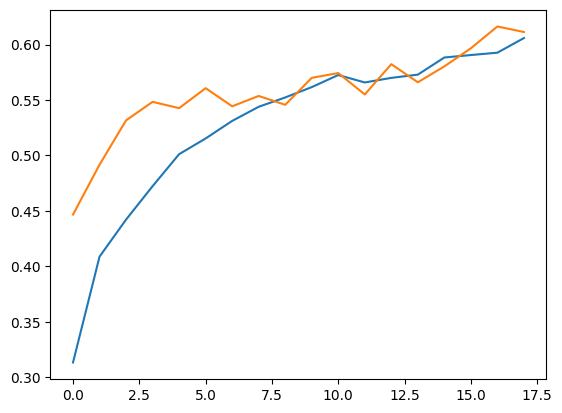

In [20]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.show()

In [21]:
CNN.evaluate(test_images,test_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7294 - loss: 1.0160


[0.9198511838912964, 0.6113333106040955]